In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns

import pandas as pd
from sklearn import cluster, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

In [2]:
import torch.utils.data as data_utils

In [3]:
# Load data
f = pd.read_csv("data.csv")
f.rename(columns={'time sample band g': 'time_g', 'time sample band r': 'time_r',
                    'time sample band i': 'time_i','total flux + noise band g': 'tfnbg',
                    'total flux + noise band r': 'tfnbr', 'total flux + noise band i': 'tfnbi',}, inplace=True)

In [4]:
f

,ID,images,time_g,tfnbg,time_r,tfnbr,time_i,tfnbi
0,0,4,54938.6681,7572.989092,54937.6681,8542.954277,54943.0681,6529.258344
1,0,4,54939.4681,10080.689824,54938.4681,-7.176116,54947.2681,24985.914708
2,0,4,54941.2681,8422.260365,54943.2681,13005.615069,54952.4681,34731.665677
3,0,4,54943.0681,248.092027,54945.0681,9076.938363,54961.6681,29784.049679
4,0,4,54944.8681,2014.486762,54945.8681,3588.299860,54966.8681,32064.179478
...,...,...,...,...,...,...,...,...
909995,9999,1,55127.6000,-723.280708,55111.6000,-1334.525828,55427.4000,-7034.464567
909996,9999,1,55129.4000,-1837.549014,55113.4000,2443.752274,55433.6000,-3624.115209
909997,9999,1,55130.2000,-4673.476731,55114.2000,104.316409,55434.8000,6050.959854
909998,9999,1,55132.0000,-1556.095817,55116.0000,-9431.789772,55438.0000,-607.507339


In [5]:
def standard(dataset):
    
    scaler = MinMaxScaler(feature_range = (0, 1))
    #scaler = StandardScaler
    
    df = 0
    dfbis = 0
    for ide, group in dataset.groupby('ID'):

        a = dataset[dataset.ID == ide]
        c = a['images']
        data = a[a.columns[2:]]
        data = pd.DataFrame(scaler.fit_transform(data), columns=dataset.columns[2:])

        if ide == 0:
            df = pd.concat([c, data], axis=1)
        else:
            dfbis = pd.concat([c.reset_index(), data], axis = 1)
            df = pd.concat([df, dfbis])

            
    del df['index']
    return df

In [7]:
f = standard(f)

In [8]:
f

,images,time_g,tfnbg,time_r,tfnbr,time_i,tfnbi
0,4,0.000000,0.548585,0.000000,0.473510,0.000000,0.362681
1,4,0.004908,0.601900,0.005298,0.325793,0.008787,0.733663
2,4,0.015951,0.566641,0.037086,0.550610,0.019665,0.929554
3,4,0.026994,0.392856,0.049007,0.482736,0.038912,0.830106
4,4,0.038037,0.430410,0.054305,0.387910,0.049791,0.875937
...,...,...,...,...,...,...,...
86,1,0.951190,0.445596,0.952318,0.185045,0.960752,0.026846
87,1,0.961905,0.404079,0.964238,0.271390,0.973695,0.056696
88,1,0.966667,0.298415,0.969536,0.217927,0.976200,0.141380
89,1,0.977381,0.414566,0.981457,0.000000,0.982881,0.083100


In [9]:
feature_columns = f.columns.tolist()[1:3]
feature_columns

['time_g', 'tfnbg']

In [10]:
train = f[:91*8000]
val = f[91*8000:91*9000]
test = f[91*9000:]

In [11]:
def dataframe_to_dataset(f):
    targets = torch.IntTensor(f['images'].values)
    features = torch.tensor(f[feature_columns].values)
    print(len(targets))
    return TensorDataset(features, targets)

In [12]:
TrainSet = dataframe_to_dataset(train)
TestSet = dataframe_to_dataset(test)
ValSet = dataframe_to_dataset(val)

728000
91000
91000


In [13]:
TrainSet

In [145]:
class SequenceModel(nn.Module):
    
    def __init__(self, n_features, n_classes, n_hidden=128, n_layers=3):
        
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layers,
            batch_first = True,
            dropout = 0.75
        )
        self.classifier = nn.Linear(n_hidden, n_classes)
    
    def forward(self, x):
        self.lstm.flatten_parameters()
        lstm_out, (ht, ct) = self.lstm(x)
        
        pred = self.classifier(lstm_out[-1])
        return pred
        

In [146]:
torch.manual_seed(0)

In [147]:
model = SequenceModel(n_features = 2, 
                        n_classes = 4)
model = model.float()

In [148]:
print(model)

SequenceModel(
  (lstm): LSTM(2, 128, num_layers=3, batch_first=True, dropout=0.75)
  (classifier): Linear(in_features=128, out_features=4, bias=True)
)


In [149]:
N_epochs = 2

In [150]:
TrainLoader = data_utils.DataLoader(TrainSet, batch_size = 91, shuffle = False)
ValLoader = data_utils.DataLoader(ValSet, batch_size = 91, shuffle = False)
TestLoader = data_utils.DataLoader(TestSet, batch_size = 91, shuffle = False)


In [151]:
TrainLoader

In [152]:
ValLoader

In [153]:
TestLoader

In [154]:
loss_function = nn.CrossEntropyLoss()

In [155]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [157]:
losses = []  
gradient =[]

#i=0
model = model.float()
for epoch in range(N_epochs):  # Loop over epochs
    running_loss = 0.0
   
    for features, label in TrainLoader:
        
        # Forward Propagation 
        labels_pred = model(features.float())

        label = torch.tensor(np.array(label[0].item() -1)).to(torch.long)
        
        labels_pred = torch.tensor(labels_pred.detach().numpy(), requires_grad=True)

        # Loss computation
        loss = loss_function(labels_pred, label)
        #loss.requires_grad = True
        
        
        # Save loss for future analysis
        losses.append(loss.item())

        # Erase previous gradients
        optimizer.zero_grad()
        
        # Compute gradients (backpropagation)
        loss.backward()
        #print(loss.backward(retain_graph=True))
        #gradient.append(loss.backward())

        # Weight update
        optimizer.step()
        
        # print statistics
#        running_loss += loss.item()
#        if i % 10 == 9:    
#            print('[Epoque : %d, iteration: %5d] loss: %.3f' %
#                  (epoch + 1, i + 1, running_loss / 10))
#            running_loss = 0.0
#        i+=1        
   
    print('Training done')

Training done
Training done


In [ ]:
val_losses = []
for epoch in range(N_epochs):  # Loop over epochs
    running_loss = 0.0
   
    for features, labels in ValLoader:
        
        # Forward Propagation 
        labels_pred = model(features.float())
        label = torch.tensor(np.array(labels[0].item() -1)).to(torch.long)
 
        labels_pred = torch.tensor(labels_pred.detach().numpy(), requires_grad=True)

        # Loss computation
        loss = loss_function(labels_pred, label)
        #print(loss)
        # Save loss for future analysis
        val_losses.append(loss.item())
        
    print('Training done')

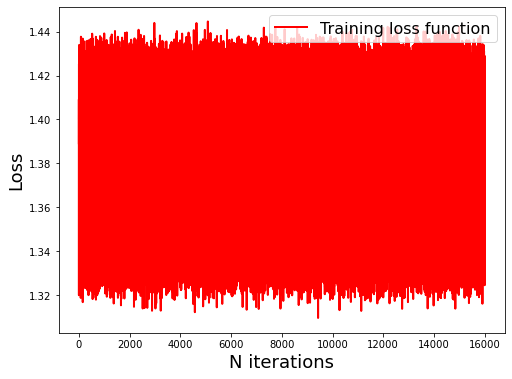

In [158]:
# Display loss evolution
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(losses,'r-',lw=2,label='Training loss function')
#axes.plot(val_losses,'b-',lw=2,label='Validation loss function')
axes.set_xlabel('N iterations',fontsize=18)
axes.set_ylabel('Loss',fontsize=18)
plt.legend(loc='upper right',fontsize=16)